# SHAP 튜토리얼: 모델 불가지론적 방법으로 모델 해석 (Model Agnostic Explanations)
  - SHapley Additive exPlanations, SHAP
  - Red Wine Quality 예측 문제
  ## Index
 
 1) 실습 환경 만들기
 
 2) 따라하기: SHAP 실습: DeepExplainer, KernelExplainer, TreeExplainer
 
 3) 적용하기: SHAP 활용: Red Wine Quality

## 1) 실습 환경 만들기 Google Colab
### SHAP 모듈 설치 방법
#### 설치 방법 - PyPI로 설치 (pip install)

In [0]:
# SHAP 모듈 설치
!pip install shap

#### 구글 드라이브와 Colab 연동

In [0]:
# 구글 드라이브와 Colab 연동
from google.colab import drive
drive.mount('/content/drive') # 출력되는 URL에 접속하여 verification code 복사 및 붙여넣기

In [0]:
# 작업할 path로 변경
import os
os.chdir('/content/drive/My Drive/PyConKorea2019-Tutorials/SHAP') 
os.listdir(os.getcwd()) # 현재 path에 존재하는 파일 목록 확인

In [0]:
# 현재 path 확인
os.getcwd() 

In [0]:
# 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore')

## 2) 따라하기: SHAP 실습
### DeepExplainer
#### MNIST classification with keras

In [0]:
# 사용할 패키지 불러오기
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [0]:
# 데이터셋 불러와서 훈련셋과 검증셋 분리
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [0]:
# 데이터셋 전처리
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

In [0]:
# 원핫인코딩 (one-hot encoding) 처리
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
# 모델 구성
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [0]:
model.summary()

In [0]:
# 모델 학습과정 설정
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [0]:
# 모델 학습
batch_size = 128
epochs = 2
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

In [0]:
# 모델 평가
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
# 설명 모듈 불러오기
import shap
import numpy as np

In [0]:
# shapley value 계산을 위한 백그라운드 데이터 셋 랜덤으로 선택
background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]

In [0]:
# 설명 모델 생성
explainer = shap.DeepExplainer(model, background)

In [0]:
# 테스트 입력 영상 데이터에 대한 Shap value 계산
test_sample = x_test[15:18]
shap_values = explainer.shap_values(test_sample)

# 입력 데이터 공헌도 시각화
shap.image_plot(shap_values, test_sample)

## KernelExplainer

### Iris classification with sklearn


In [0]:
!pip install shap

In [0]:
# 사용할 모듈 불러오기
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import shap

In [0]:
# Iris 데이터 불러오기
d = sklearn.datasets.load_iris()
df = pd.DataFrame(data=d.data, columns=d.feature_names)

In [0]:
df

In [0]:
print(d.target_names)
print(d.target)

In [0]:
# 훈련셋과 테스트셋으로 분리
X_train,X_test,Y_train,Y_test = train_test_split(df, d.target,
                                                 test_size=0.2, random_state=0)

In [0]:
# 분류기 모델 정의
classifier = sklearn.linear_model.LogisticRegression()

In [0]:
# 분류기 모델 학습
classifier.fit(X_train, Y_train)

In [0]:
# 분류 정확도 출력
def print_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == Y_test)/len(Y_test)))

print_accuracy(classifier.predict)

In [0]:
# 설명 모델 생성
explainer = shap.KernelExplainer(classifier.predict_proba, X_train)

In [0]:
# shapley value 계산
test_sample = X_test[0:1]
shap_values = explainer.shap_values(test_sample)

# shapley value 시각화
shap.initjs()
classNumber = 0 # 0: setosa / 1: versicolor / 2: virginica
shap.force_plot(explainer.expected_value[classNumber], 
                shap_values[classNumber], test_sample)

In [0]:
shap.initjs()
classNumber = 1 # 0: setosa / 1: versicolor / 2: virginica
shap.force_plot(explainer.expected_value[classNumber], 
                shap_values[classNumber], test_sample)

In [0]:
shap.initjs()
classNumber = 2 # 0: setosa / 1: versicolor / 2: virginica
shap.force_plot(explainer.expected_value[classNumber], 
                shap_values[classNumber], test_sample)

In [0]:
Y_test

In [0]:
X_test

## TreeExplainer

### boston house prices regression with xgboost

In [0]:
# 사용할 모듈 불러오기
import xgboost
import pandas as pd
import shap

In [0]:
# boston 데이터 불러오기
d = sklearn.datasets.load_boston()
df = pd.DataFrame(data=d.data, columns=d.feature_names)
X = df
y = d.target

In [0]:
X.shape

In [0]:
y.shape

In [0]:
X.head(1)

특징 데이터 X:
- CRIM: 범죄율
- INDUS: 비소매상업지역 면적 비율
- NOX: 일산화질소 농도
- RM: 주택당 방 수
- LSTAT: 인구 중 하위 계층 비율
- B: 인구 중 흑인 비율
- PTRATIO: 학생/교사 비율
- ZN: 25,000 평방피트를 초과 거주지역 비율
- CHAS: 찰스강의 경계에 위치한 경우는 1, 아니면 0
- AGE: 1940년 이전에 건축된 주택의 비율
- RAD: 방사형 고속도로까지의 거리
- DIS: 직업센터의 거리
- TAX: 재산세율

In [0]:
y[0:10]

타겟 데이터 y:
- 1978 보스턴 주택 가격
- 506개 타운의 주택 가격 중앙값 (단위 1,000 달러)

In [0]:
# 예측 모델 학습(XGBoost)
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

In [0]:
# 설명 모델 생성
explainer = shap.TreeExplainer(model)
# shapley value 계산
shap_values = explainer.shap_values(X)

In [0]:
# 하나의 데이터에 대해 shapley value 시각화
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [0]:
# 학습 데이터 전체에 대해 시각화
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X)

## 3) 적용하기: SHAP 활용
### Red Wine Quality
#### Classification with XGBClassifier

In [0]:
## 사용할 모듈 불러오기
# 연산 모듈
import pandas as pd
import numpy as np
# 시각화 모듈
import matplotlib.pyplot as plt
import seaborn as sns 
# 데이터 처리 모듈
from sklearn.model_selection import train_test_split
# 행렬 연산 모듈
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
# xgboost 모델 모듈
from xgboost import XGBClassifier, plot_importance
# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')
# 그래프 스타일 설정
plt.style.use('fivethirtyeight')
%matplotlib inline

In [0]:
# csv 파일 레드 와인 데이터 불러오기
wines = pd.read_csv('/content/drive/My Drive/PyConKorea2019-Tutorials/SHAP/winequality-red.csv')

In [0]:
wines.info()

In [0]:
wines.shape

특징 데이터:
- fixed acidity: 고정 산도
- volatile acidity: 휘발성 산도
- citric acid: 구연산
- residual sugar: 자연 발효로 생성된 당분
- chlorides: 염소
- free sulfur dioxide: 유황 이산화황
- total sulfur dioxide: 총 이산화황
- density: 밀도
- pH
- sulphates: 황산염
- alcohol: 알코올
- quality (score between 0 and 10): 품질(0~10점)

In [0]:
# 레드 와인 데이터 중 분류 문제를 풀기위해 의미 있는 feature 목록으로 만들기 (데이터 전처리)
target = 'quality' # 타겟 추출
features_list = list(wines.columns) # 특징 리스트를 본다.
features_list.remove(target) # target 데이터를 지운다.
y = wines.pop('quality') # 타겟 데이터를 위한 벡터를 생성하고 이름을 입력한다.
y = y.apply(lambda x: 0 if x <= 5 else 1) # quality 점수가 5점 이하면 타겟 값은 0 아니면 1로 벡터값을 입력한다.
y.sum() / len(y) # target 값이 잘 분배되었는지 검증한다.

In [0]:
# 훈련 셋과 테스트 셋으로 분리
X_train, X_test, y_train, y_test = train_test_split(wines, y, test_size=0.3, random_state=0)
X_train.shape, X_test.shape

In [0]:
# xgboost 분류기 생성
xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)

# xgboost 분류기 학습
xgb.fit(X_train, y_train)

In [0]:
# 분류율 평가 함수
def evaluation_scores(test, prediction, target_names=None):
    print('Accuracy:', np.round(metrics.accuracy_score(test, prediction), 4)) 
    print('-'*60)
    print('classification report:\n\n', metrics.classification_report(y_true=test, y_pred=prediction, target_names=target_names)) 
    
    classes = [0, 1]
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=test, y_pred=prediction, labels=classes)
    cm_frame = pd.DataFrame(data=cm, columns=pd.MultiIndex(levels=[['Predicted:'], classes], labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], labels=level_labels))
    
    print('-'*60)
    print('Confusion matrix:\n')
    print(cm_frame)
    
# 학습 모델 성능 평가
xgb_predictions = xgb.predict(X_test)
evaluation_scores(y_test, xgb_predictions, target_names=['Low Quality', 'Hight Quality'])

In [0]:
# 설명 모델 생성
explainer = shap.TreeExplainer(xgb)
# shapley value 계산
shap_values = explainer.shap_values(X_test)

### Predicting when a particular wine quality will be <= 5 ('Low Quality')

In [0]:
# 테스트 데이터 1개 샘플로 시각화
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

### Predicting when a particular wine quality will be > 5 ('Hight Quality')

In [0]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[4,:], X_test.iloc[4,:])

### Visualizing and explaining multiple predictions

In [0]:
# 테스트 데이터 여러 샘플로 시각화
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test.iloc[:1000,:])

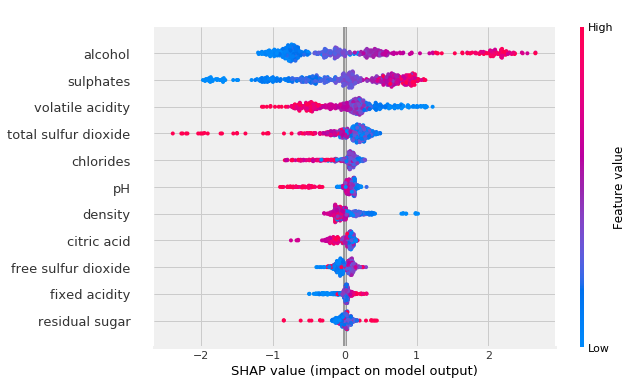

In [0]:
# 입력 feature 요약
shap.initjs()
shap.summary_plot(shap_values, X_test)